In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import math

%matplotlib inline

# Initial Data Load

In [2]:
data = pd.read_csv('fake_job_postings.csv')

In [3]:
data.shape

(17880, 18)

In [4]:
data.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Data Exploration

In [5]:
data.isna().any()

job_id                 False
title                  False
location                True
department              True
salary_range            True
company_profile         True
description             True
requirements            True
benefits                True
telecommuting          False
has_company_logo       False
has_questions          False
employment_type         True
required_experience     True
required_education      True
industry                True
function                True
fraudulent             False
dtype: bool

Proportion of fraud: 0.04843
Total accounts of fraud: 866


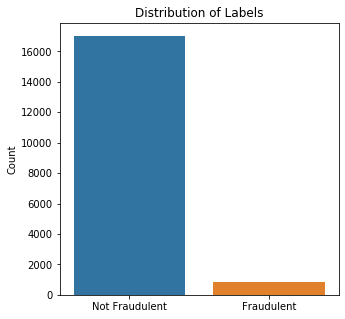

In [6]:
data['fraudulent'].value_counts()

f, ax = plt.subplots(figsize=(5,5))
sns.barplot(x=['Not Fraudulent', 'Fraudulent'], y=data['fraudulent'].value_counts(), ax=ax)

ax.set_title('Distribution of Labels')
ax.set_ylabel('Count');

print("Proportion of fraud: {}".format(round(np.mean(data['fraudulent']),5)))
print("Total accounts of fraud: {}".format(sum(data['fraudulent'])))

In [7]:
for column in data.columns:
    print('{}:'.format(column), round(sum(data[column].isna()) / data.shape[0],2))

job_id: 0.0
title: 0.0
location: 0.02
department: 0.65
salary_range: 0.84
company_profile: 0.19
description: 0.0
requirements: 0.15
benefits: 0.4
telecommuting: 0.0
has_company_logo: 0.0
has_questions: 0.0
employment_type: 0.19
required_experience: 0.39
required_education: 0.45
industry: 0.27
function: 0.36
fraudulent: 0.0


Categorical variables that might be worth exploring (small # of separable groups):

    1. Employment Type (6 classes, 19% missing)
    2. Required Experience (8 classes, 39% missing) - Too many missing
    3. Required Education (14 classes, 45% missing) - Too many missing

In [8]:
#Breadth of categorical variables:
print('# of unique titles: ', len(set(data['title'])))
print('# of unique locations: ', len(set(data['location'])))
print('# of unique departments: ', len(set(data['department'])))
print('# of unique salary ranges: ', len(set(data['salary_range'])))
print('# of unique employment type: ', len(set(data['employment_type'])))
print('# of unique required experiences: ', len(set(data['required_experience'])))
print('# of unique required education: ', len(set(data['required_education'])))
print('# of unique industries: ', len(set(data['industry'])))
print('# of unique functions: ', len(set(data['function'])))

data['employment_type'].fillna('None', inplace = True)

# of unique titles:  11231
# of unique locations:  3106
# of unique departments:  1338
# of unique salary ranges:  875
# of unique employment type:  6
# of unique required experiences:  8
# of unique required education:  14
# of unique industries:  132
# of unique functions:  38


### Employment Type Analysis:

In [9]:
employment_group = data.groupby('employment_type').count()['job_id']
employment_group = employment_group / sum(employment_group)

fraudelent_set = data[data['fraudulent'] == 1].copy()
fraudulent_group = fraudelent_set.groupby('employment_type').count()['job_id']
fraudulent_group = fraudulent_group / sum(fraudulent_group)

combined_employ_group = pd.concat([pd.DataFrame(employment_group), pd.DataFrame(fraudulent_group)], axis = 0)
combined_employ_group['fraud'] = [0,0,0,0,0,0,1,1,1,1,1,1]
combined_employ_group['employment_type'] = combined_employ_group.index

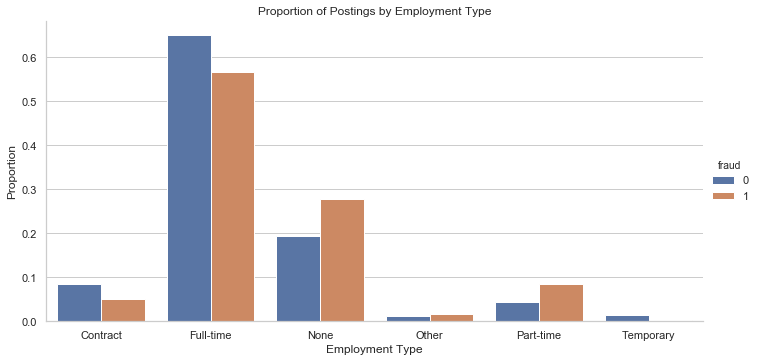

In [10]:
sns.set(style="whitegrid")
sns.catplot(x='employment_type', y='job_id', hue='fraud', data=combined_employ_group, kind='bar', height=5, aspect=2)

plt.title('Proportion of Postings by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Proportion');

#Fraud slightly overpresented in the None and Part-time job categories

In [11]:
data.groupby('employment_type').mean()['fraudulent']

employment_type
Contract     0.028871
Full-time    0.042169
None         0.069432
Other        0.066079
Part-time    0.092848
Temporary    0.008299
Name: fraudulent, dtype: float64

### Salary Analysis:

Ranges vary widely (and not all measured at the same rate or currency); we'll look at whether or not salary information is included or not.

In [12]:
data['has_salary'] = ~data['salary_range'].isnull()

salary_group = data.groupby('has_salary').mean()['fraudulent']
salary_group

has_salary
False    0.042832
True     0.077755
Name: fraudulent, dtype: float64

Text(0.5, 0, 'Includes Salary Detail')

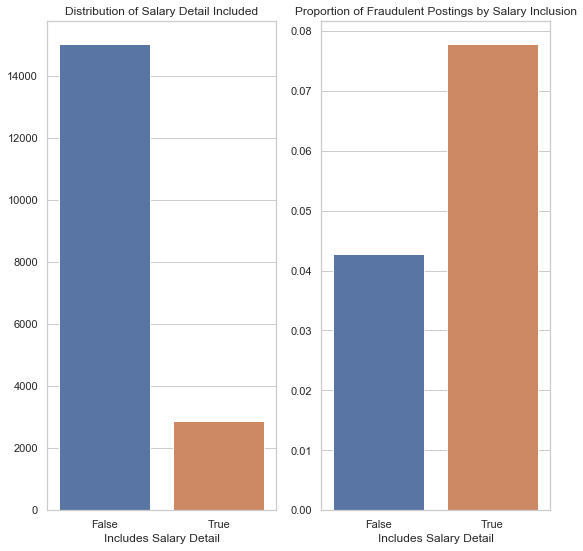

In [13]:
f, ax = plt.subplots(1, 2, figsize=(9,9))
sns.barplot(x=data.has_salary.value_counts().index, y = data.has_salary.value_counts().values, ax=ax[0])
sns.barplot(x=salary_group.index, y=salary_group.values, ax=ax[1])

ax[0].set_title('Distribution of Salary Detail Included')
ax[1].set_title('Proportion of Fraudulent Postings by Salary Inclusion')
ax[0].set_xlabel('Includes Salary Detail')
ax[1].set_xlabel('Includes Salary Detail')
#Fraudulent jobs overrepresented in job postings with salaries:

### Analysis of Job Description:

In [14]:
from collections import Counter
from gensim.parsing import preprocessing
import nltk
import string
import html
from lexical_diversity import lex_div as ld

In [15]:
corpus = data['description'].copy()
corpus.fillna('', inplace = True)

corpus.isnull().any()

False

### Pipeline

    1. Count Punctuation
    2. Count Numbers
    3. Count links

In [16]:
def count_punctuation(text):
    
    count = 0
    
    c = Counter(text)
    for item in string.punctuation:
        try:
            count+=c[item]
        except:
            pass
    
    return count

def count_number(text):
    
    count = 0
    
    c = Counter(text)
    for item in np.arange(0, 10).astype(str):
        try:
            count+=c[item]
        except:
            pass
    
    return count

def find_url(text):
    
    #Observed pattern of urls:
    url_pattern = re.compile(r'#URL.*?#')
    
    #See if this matches just the text URL or url:
    url = re.compile(r'url|URL')
    
    return re.findall(url_pattern, text)
    
    

In [17]:
urls = corpus.apply(lambda x: find_url(x))

url_count = []

for item in urls:
    url_count.append(len(item))

In [18]:
data['num_links'] = url_count
data['num_nums'] = corpus.apply(lambda x: count_number(str(x)))
data['num_punct'] = corpus.apply(lambda x: count_punctuation(str(x)))
data['description_length'] = corpus.apply(lambda x: len(str(x)))

### Fraud by Description Length:

In [19]:
description_cuts = pd.qcut(data['description_length'], 4)
description_group = data.groupby(description_cuts.values).mean()['fraudulent']

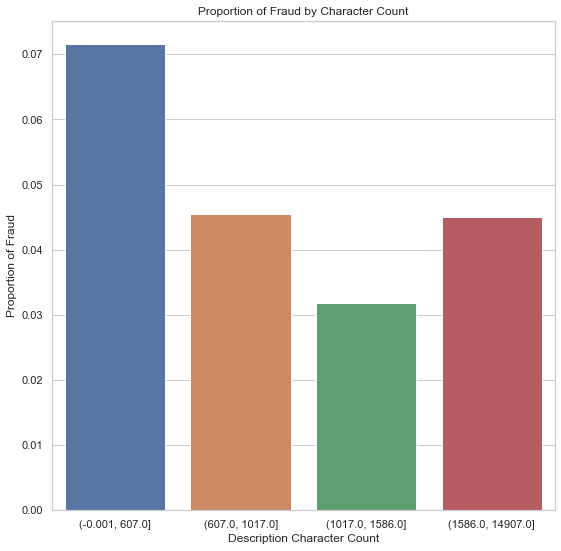

In [20]:
f, ax = plt.subplots(figsize = [9,9])

ax = sns.barplot(x=description_group.index, y=description_group.values)
ax.set_title('Proportion of Fraud by Character Count')
ax.set_xlabel('Description Character Count')
ax.set_ylabel('Proportion of Fraud');

#Fraud slightly over-represented in shorter descriptors 

# Baseline models (W/O NLP)

In [211]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, SCORERS, average_precision_score

In [22]:
data.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'has_salary', 'num_links', 'num_nums', 'num_punct',
       'description_length'],
      dtype='object')

### One-hot encode

In [23]:
mlb = MultiLabelBinarizer()
mlb.fit([data.employment_type])
mlb.classes_

employment_df = pd.DataFrame(mlb.transform([[item] for item in data.employment_type]))
employment_df.columns = mlb.classes_

employment_df

,Contract,Full-time,None,Other,Part-time,Temporary
0,0,0,0,1,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0
...,...,...,...,...,...,...
17875,0,1,0,0,0,0
17876,0,1,0,0,0,0
17877,0,1,0,0,0,0
17878,1,0,0,0,0,0


In [24]:
#Create features:
X = data[['telecommuting', 'has_company_logo', 'has_questions', 'has_salary',
             'num_nums', 'num_links', 'num_punct', 'description_length']].copy()

X = pd.concat([X, employment_df], axis = 1)
y = data['fraudulent'].copy()

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1000, stratify = y)

In [26]:
#Set up parameters
#Due to heavily imbalanced nature of dataset, analyze effect of custom loss weights 

logparams = {
    'max_iter': [5000],
    'solver': ['liblinear'],
    'class_weight':[{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 15}, {0: 1, 1: 20}]
}

rfparams = {
    'n_estimators': [100],
    'class_weight':[{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 15}, {0: 1, 1: 20}]
}

xgbparams = {
    'eta': [.01, .05, .1, .15, .2],
    'scale_pos_weight': [.05, .1, .15, .2]
}

In [27]:
logGrid = GridSearchCV(LogisticRegression(), param_grid=logparams, scoring='roc_auc')
rfGrid = GridSearchCV(RandomForestClassifier(), param_grid=rfparams, scoring='roc_auc')
xgbGrid = GridSearchCV(XGBClassifier(), param_grid=xgbparams, scoring='roc_auc')

models = [logGrid, rfGrid, xgbGrid]

In [28]:
precisions = []
recalls = []
cms = []
aucs = []
predictions = []

for model in models:
    model.fit(X_train, y_train)
    
    model_predict = model.predict(X_test)
    
    predictions.append(model_predict)
    precisions.append(precision_score(y_test, model_predict))
    recalls.append(recall_score(y_test, model_predict))
    aucs.append(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
    
    cms.append(confusion_matrix(y_test, model.predict(X_test)))
    
    

In [29]:
print('LOG Best:', models[0].best_estimator_)
print('\n')
print('RF Best:', models[1].best_estimator_)
print('\n')
print('XGB Best:', models[2].best_estimator_)

LOG Best: LogisticRegression(C=1.0, class_weight={0: 1, 1: 20}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=5000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


RF Best: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 1},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


XGB Best: XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       

Precision: [0.14791 0.81905 1.     ]


Recall: [0.6763  0.49711 0.21387]


AUC: [0.7825  0.90562 0.90853]




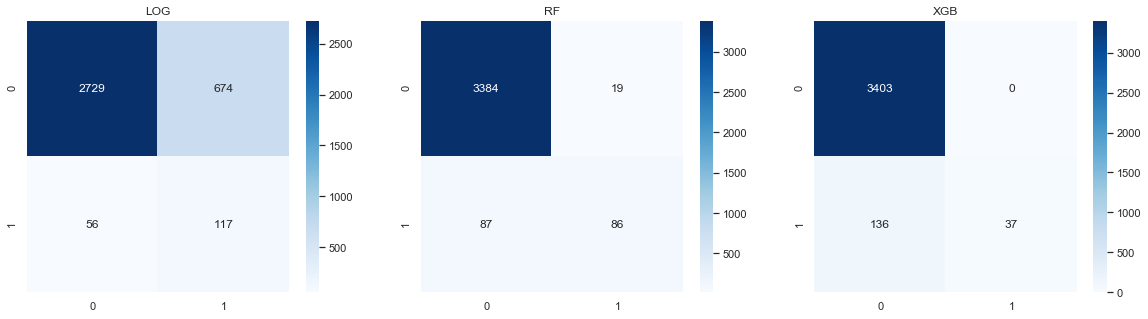

In [30]:
f, ax = plt.subplots(1, 3, figsize=(20, 5))

for i in range(0, len(cms)):
    sns.heatmap(cms[i], annot=True, fmt = 'd', cmap='Blues', ax=ax[i])

ax[0].set_title('LOG')
ax[1].set_title('RF')
ax[2].set_title('XGB');

print('Precision:', np.round(np.array(precisions),5))
print('\n')

print('Recall:', np.round(np.array(recalls),5))
print('\n')

print('AUC:', np.round(np.array(aucs),5))
print('\n')


# Prepare Description for Analysis:

In [31]:
from langdetect import DetectorFactory, detect
DetectorFactory.seed = 0

from googletrans import Translator

In [32]:
def preprocess_string(text):
    
    text = text.lower()
    text = html.unescape(text)
    text = preprocessing.strip_non_alphanum(text)
    text = preprocessing.strip_numeric(text)
    text = preprocessing.strip_multiple_whitespaces(text)
    text = preprocessing.remove_stopwords(text)
    text = preprocessing.strip_short(text, minsize=3)
    
    return text
      

In [33]:
cleaned_corpus = corpus.apply(lambda x: preprocess_string(x))

In [34]:
description_language = cleaned_corpus.apply(lambda x: detect(x) if len(x) > 0 else 'None')

In [86]:
data['language'] = description_language
data['cleaned_description'] = cleaned_corpus

to_translate = data[(data['language'] != 'en') & (data['language'] != 'None')]['cleaned_description']
no_translate = data[(data['language'] == 'en') | (data['language'] == 'None')]['cleaned_description']

In [88]:
trans = Translator()

translations = pd.Series(dtype=object)

for index, item in to_translate.items():
    try:
        translations.loc[index] = trans.translate(item).text
    except:
        print(index)
        print('error')
        break

In [89]:
#Recombine translated descriptions with English descriptions
translated_descriptions = pd.concat([translations, no_translate], axis = 0)
translated_descriptions.sort_index(inplace = True)
translated_descriptions

0        food fast growing james beard award winning on...
1        organised focused vibrant awesome passion cust...
2        client located houston actively seeking experi...
3        company esri environmental systems research in...
4        job title itemization review managerlocation f...
                               ...                        
17875    case time visited website vend award winning w...
17876    payroll accountant focus primarily payroll fun...
17877    experienced project cost control staff enginee...
17878    nemsia studios looking experienced visual grap...
17879    vend award winning web based point sale softwa...
Length: 17880, dtype: object

In [90]:
data['final_descriptions'] = translated_descriptions

In [91]:
#Save Preprocessed df:
data.to_csv('language_processed_df.csv')

### SpaCy Lemmatizing

In [35]:
data = pd.read_csv('language_processed_df.csv', index_col = 0)

In [39]:
from spacy.tokenizer import Tokenizer
import en_core_web_lg
from spacy.lemmatizer import Lemmatizer

In [42]:
data['final_descriptions'].fillna('', inplace = True)

In [37]:
nlp = en_core_web_lg.load()

In [43]:
docs = list(nlp.pipe(data['final_descriptions'], disable=['parser', 'ner']))

In [44]:
lemma_words = pd.Series(dtype=object)

for i, item in enumerate(docs):
    lemma_words.loc[i] = ' '.join([word.lemma_ for word in item])

### Visualization Distribution of Words:

In [46]:
lemma_tokens = lemma_words.apply(lambda x: nltk.word_tokenize(x))

In [47]:
fraud_index = data['fraudulent'] == 1

clean_words = []
fraud_words = []
all_words = []


for item in lemma_tokens[fraud_index]:
    fraud_words.extend(item)    


for item in lemma_tokens[~fraud_index]:
    clean_words.extend(item)
    

for item in lemma_tokens:
    all_words.extend(item)
    
c_all = Counter(all_words)
c_fraud = Counter(fraud_words)
c_clean = Counter(clean_words)

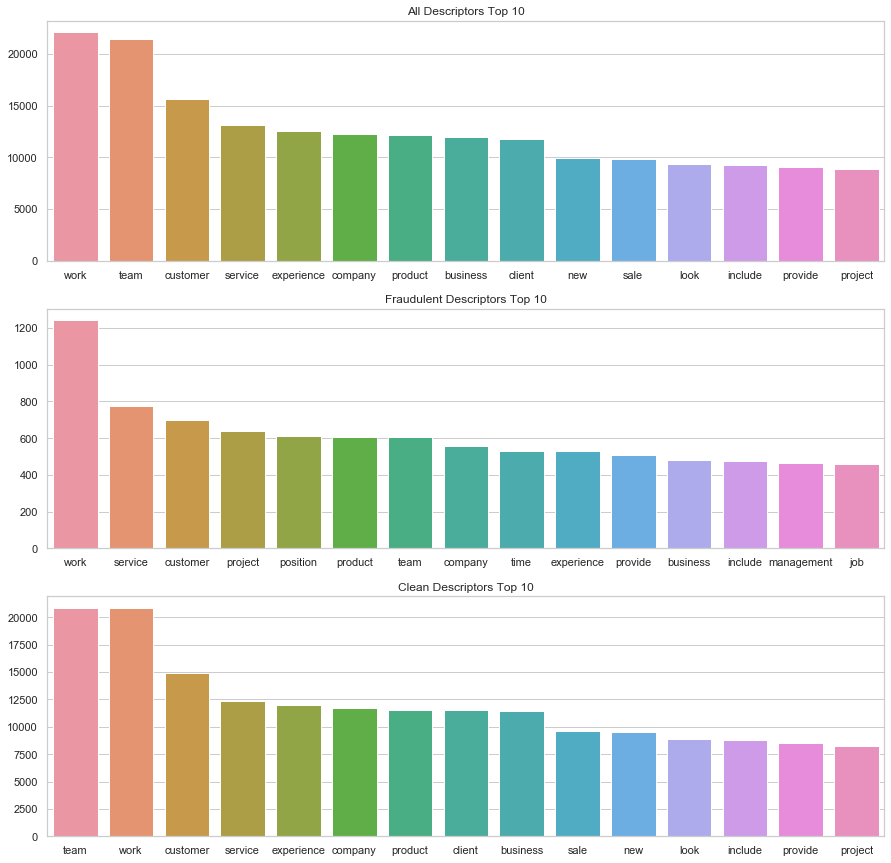

In [48]:
f, ax = plt.subplots(3, 1, figsize=(15,15))

sns.barplot(x = [item[0] for item in c_all.most_common(15)], y = [item[1] for item in c_all.most_common(15)], ax=ax[0])
sns.barplot(x = [item[0] for item in c_fraud.most_common(15)], y = [item[1] for item in c_fraud.most_common(15)], ax=ax[1])
sns.barplot(x = [item[0] for item in c_clean.most_common(15)], y = [item[1] for item in c_clean.most_common(15)], ax=ax[2])

ax[0].set_title('All Descriptors Top 10')
ax[1].set_title('Fraudulent Descriptors Top 10')
ax[2].set_title('Clean Descriptors Top 10');

In [49]:
clean_words = [item[0] for item in c_clean.most_common(15)]
fraud_words = [item[0] for item in c_fraud.most_common(15)]

In [50]:
print(len(np.union1d(clean_words, fraud_words)))
np.union1d(clean_words, fraud_words)

19


array(['business', 'client', 'company', 'customer', 'experience',
       'include', 'job', 'look', 'management', 'new', 'position',
       'product', 'project', 'provide', 'sale', 'service', 'team', 'time',
       'work'], dtype='<U10')

### Lexical Diversity of Descriptions:

In [51]:
lex_diversity = lemma_tokens.apply(lambda x: ld.ttr(x))
data['description_diversity'] = lex_diversity
data.groupby('fraudulent').mean()['description_diversity']

fraudulent
0    0.805540
1    0.806069
Name: description_diversity, dtype: float64

# Gensim FastText

In [52]:
from gensim import downloader
from gensim.models.fasttext import load_facebook_model
from gensim.test.utils import datapath

from fse import IndexedList
from fse.models import Average, uSIF
from fse.models.average import FAST_VERSION

In [53]:
fb_model = downloader.load('fasttext-wiki-news-subwords-300')

In [54]:
s = IndexedList(lemma_tokens.to_list())
sif_model = uSIF(fb_model, lang_freq='en')
sif_model.train(s)

C:\Users\lzeng\AppData\Local\Continuum\anaconda3\envs\nlp\lib\site-packages\fse\models\base_s2v.py:172: UserWarning: C extension not loaded, training/inferring will be slow. Install a C compiler and reinstall fse.
  "C extension not loaded, training/inferring will be slow. "


(17880, 1754079)

In [55]:
sif_vecs = []
for i in range(0, data.shape[0]):
    sif_vecs.append(sif_model.sv[i])

sif_vecs = pd.read_csv('SIF_Vectors.csv', index_col = 0)

In [56]:
sif_vecs = sif_vecs.to_numpy()

### Models with SIF Sentence Embeddedings of Description:

In [57]:
X = pd.DataFrame(sif_vecs)
y = data['fraudulent']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 0, stratify = y)
print(X_train.shape, y_train.shape)

(14304, 300) (14304,)


In [59]:
log_params = {
    'C': [.25, .5, 1],
    'max_iter': [5000],
    'penalty': ['l1'],
    'solver': ['saga'],
    'class_weight':[{0: 1, 1: 1}, {0: 1, 1: 10}, {0: 1, 1: 20}]
    }

rf_params = {
    'n_estimators': [100],
    'class_weight':[{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 15}, {0: 1, 1: 20}]
    }

xgb_params = {
    'eta': [.01, .05, .1, .2],
    'scale_pos_weight': [.05, .1, .2]
}

In [60]:
logGrid = GridSearchCV(LogisticRegression(), param_grid=log_params, verbose = 1, cv = 3, scoring = 'roc_auc')
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid=rf_params, cv=3, scoring = 'roc_auc', verbose = 1)
xgb_grid = GridSearchCV(XGBClassifier(), param_grid=xgb_params, cv=3, scoring = 'roc_auc', verbose = 1)

In [61]:
logGrid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  4.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.25, 0.5, 1],
                         'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 10},
                                          {0: 1, 1: 20}],
                         'max_iter': [5000], 'penalty': ['l1'],
                         'solver': ['saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_scor

In [62]:
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  2.2min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [63]:
xgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  6.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=Non

In [64]:
print(logGrid.best_estimator_)
print(rf_grid.best_estimator_)
print(xgb_grid.best_estimator_)

LogisticRegression(C=1, class_weight={0: 1, 1: 20}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=5000, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1, 1: 10}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_by

In [65]:
def get_metrics(model):
    score = model.score(X_test, y_test)
    predictions = model.predict(X_test)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    
    print('AUC:', round(score,5))
    print('Precision:', round(precision,5))
    print('Recall:', round(recall, 5))
    sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'Blues')
    
    return None

AUC: 0.87826
Precision: 0.18373
Recall: 0.80925


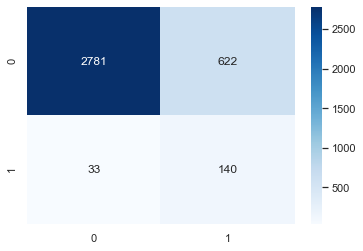

In [66]:
get_metrics(logGrid)

AUC: 0.94691
Precision: 0.97468
Recall: 0.44509


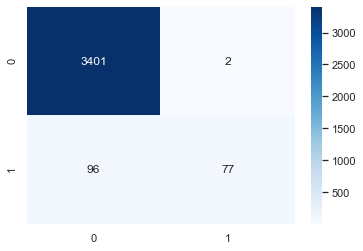

In [67]:
get_metrics(rf_grid)

AUC: 0.93637
Precision: 0.97468
Recall: 0.44509


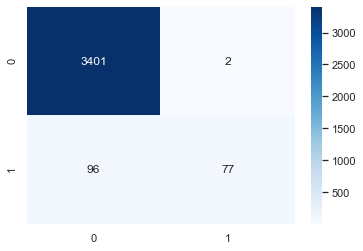

In [68]:
get_metrics(xgb_grid)

# MLP Model:

In [130]:
from tensorflow.keras.layers import Layer, Dense, Input, Dropout, Activation, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [70]:
es = EarlyStopping(
  monitor='accuracy', min_delta=0.0001,
  patience=5)

In [71]:
def get_model(dropout, n_size, input_size, optimizer):
    model = Sequential()
    model.add(Dense(n_size, input_dim=input_size, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss = 'binary_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

    return model


In [72]:
nn_params = {
    'dropout': [.2, .4],
    'n_size': [64, 128],
    'input_size': [X_train.shape[1]],
    'epochs': [20],
    'optimizer': ['adam']
}


In [73]:
mod = KerasClassifier(build_fn=get_model)
keras_grid = GridSearchCV(estimator=mod, param_grid=nn_params, cv=2, scoring = 'roc_auc')

In [74]:
keras_grid.fit(X_train, y_train, callbacks =[es])

Train on 7152 samples
Epoch 1/20
7152/7152 [==============================] - 1s 89us/sample - loss: 0.3324 - accuracy: 0.9460
Epoch 2/20
7152/7152 [==============================] - 0s 46us/sample - loss: 0.1824 - accuracy: 0.9474
Epoch 3/20
7152/7152 [==============================] - 0s 49us/sample - loss: 0.1692 - accuracy: 0.9492
Epoch 4/20
7152/7152 [==============================] - 0s 45us/sample - loss: 0.1579 - accuracy: 0.9512
Epoch 5/20
7152/7152 [==============================] - 0s 45us/sample - loss: 0.1504 - accuracy: 0.9532
Epoch 6/20
7152/7152 [==============================] - 0s 45us/sample - loss: 0.1431 - accuracy: 0.9540
Epoch 7/20
7152/7152 [==============================] - 0s 43us/sample - loss: 0.1375 - accuracy: 0.9562
Epoch 8/20
7152/7152 [==============================] - 0s 45us/sample - loss: 0.1346 - accuracy: 0.9574
Epoch 9/20
7152/7152 [==============================] - 0s 45us/sample - loss: 0.1289 - accuracy: 0.9585
Epoch 10/20
7152/7152 [==========

7152/7152 [==============================] - 0s 48us/sample - loss: 0.0883 - accuracy: 0.9725
Epoch 18/20
7152/7152 [==============================] - 0s 46us/sample - loss: 0.0853 - accuracy: 0.9726
Epoch 19/20
7152/7152 [==============================] - 0s 45us/sample - loss: 0.0847 - accuracy: 0.9726
Epoch 20/20
7152/7152 [==============================] - 0s 46us/sample - loss: 0.0825 - accuracy: 0.9740
Train on 7152 samples
Epoch 1/20
7152/7152 [==============================] - 1s 72us/sample - loss: 0.3371 - accuracy: 0.9420
Epoch 2/20
7152/7152 [==============================] - 0s 41us/sample - loss: 0.1856 - accuracy: 0.9474
Epoch 3/20
7152/7152 [==============================] - 0s 43us/sample - loss: 0.1734 - accuracy: 0.9483
Epoch 4/20
7152/7152 [==============================] - 0s 43us/sample - loss: 0.1654 - accuracy: 0.9505
Epoch 5/20
7152/7152 [==============================] - 0s 42us/sample - loss: 0.1573 - accuracy: 0.9520
Epoch 6/20
7152/7152 [===================

7152/7152 [==============================] - 0s 47us/sample - loss: 0.1041 - accuracy: 0.9688
Epoch 14/20
7152/7152 [==============================] - 0s 45us/sample - loss: 0.1010 - accuracy: 0.9694
Epoch 15/20
7152/7152 [==============================] - 0s 46us/sample - loss: 0.0978 - accuracy: 0.9702
Epoch 16/20
7152/7152 [==============================] - 0s 46us/sample - loss: 0.0959 - accuracy: 0.9695
Epoch 17/20
7152/7152 [==============================] - 0s 46us/sample - loss: 0.0954 - accuracy: 0.9698
Epoch 18/20
7152/7152 [==============================] - 0s 46us/sample - loss: 0.0939 - accuracy: 0.9705
Epoch 19/20
7152/7152 [==============================] - 0s 48us/sample - loss: 0.0911 - accuracy: 0.9722
Epoch 20/20
7152/7152 [==============================] - 0s 47us/sample - loss: 0.0902 - accuracy: 0.9723
Train on 14304 samples
Epoch 1/20
14304/14304 [==============================] - 1s 54us/sample - loss: 0.2340 - accuracy: 0.9502
Epoch 2/20
14304/14304 [==========

GridSearchCV(cv=2, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001FC5622EDC8>,
             iid='deprecated', n_jobs=None,
             param_grid={'dropout': [0.2, 0.4], 'epochs': [20],
                         'input_size': [300], 'n_size': [64, 128],
                         'optimizer': ['adam']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [75]:
keras_grid.best_estimator_.get_params()

{'dropout': 0.2,
 'epochs': 20,
 'input_size': 300,
 'n_size': 128,
 'optimizer': 'adam',
 'build_fn': <function __main__.get_model(dropout, n_size, input_size, optimizer)>}

AUC: 0.90991
Precision: 0.81633
Recall: 0.46243


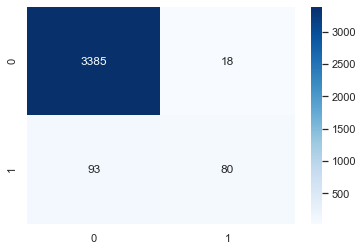

In [76]:
get_metrics(keras_grid)

# LSTM/GRU

In [182]:
from tensorflow.keras.layers import LSTM, GRU, SpatialDropout1D, Embedding, Bidirectional, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.layers import concatenate
import tqdm
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

In [101]:
max_features = 30000 #max number of words to include
max_len = 300 #max length of a sentence
embed_size = 300 #FB FastText embedding size

keras_tokenizer = Tokenizer(num_words=max_features) #max number of words to include from dictionary
keras_tokenizer.fit_on_texts(lemma_tokens) 

X = keras_tokenizer.texts_to_sequences(data['final_descriptions'])
X = sequence.pad_sequences(X, maxlen=max_len)

#keras_tokenizer.word_index an index of words sorted by most common
word_index = keras_tokenizer.word_index

#embed matrix will be an (X x p) matrix:
    #X: top-X most common words to include 
    #p: embedding size = 300

nb_words = min(max_features, len(word_index))
    
embed_matrix = np.zeros((nb_words, embed_size))

for word, i in word_index.items():
    if i >= nb_words: 
        continue
    try:
        embed_vector = fb_model.get_vector(word)
    except:
        embed_vector = None
    
    if embed_vector is not None:
        embed_matrix[i] = embed_vector

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1000, stratify=y)

In [80]:
def get_LSTM_GRU_model(dropout, n_size, use_GRU: False):
    inp = Input(shape=(max_len,)) #length of sentence
    
    x=Embedding(max_features, embed_size, weights=[embed_matrix])(inp)
    x=Dense(n_size, activation='relu')(x)
    x=SpatialDropout1D(dropout)(x)
    
    if use_GRU:
        x=Bidirectional(GRU(n_size, return_sequences=True))(x)
    else:    
        x=Bidirectional(LSTM(n_size, return_sequences=True))(x)
    
    avg_pool = GlobalAvgPool1D()(x)
    max_pool = GlobalMaxPool1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(1, activation='sigmoid')(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model
    

In [81]:
lstm_mod = get_LSTM_GRU_model(.2, 64, False)

In [82]:
lstm_mod.fit(X_train, y_train, batch_size=32, epochs = 2)

Train on 14304 samples
Epoch 1/2
14304/14304 [==============================] - 112s 8ms/sample - loss: 0.1565 - accuracy: 0.9573
Epoch 2/2
14304/14304 [==============================] - 118s 8ms/sample - loss: 0.0773 - accuracy: 0.9764


In [83]:
lstm_predictions = lstm_mod.predict(X_test, batch_size=1024)

In [84]:
roc_auc_score(y_test, lstm_predictions)

0.9579578712424772

In [85]:
def predict_threshold(preds, threshold):
    
    temp = preds.flatten()
    temp = np.array(temp > threshold, dtype=int)
    
    return temp
    

In [86]:
for i in np.linspace(0, 1, 9):
    print(i)
    prec_score = precision_score(y_test, predict_threshold(lstm_predictions, i))
    rec_score = recall_score(y_test, predict_threshold(lstm_predictions, i))
    total = prec_score + rec_score
    print('Precision:', prec_score)
    print('Recall:', rec_score)
    print('Total:', total)
    print('\n')

0.0
Precision: 0.04837807606263982
Recall: 1.0
Total: 1.0483780760626398


0.125
Precision: 0.7411764705882353
Recall: 0.7283236994219653
Total: 1.4695001700102006


0.25
Precision: 0.8518518518518519
Recall: 0.6647398843930635
Total: 1.5165917362449153


0.375
Precision: 0.8852459016393442
Recall: 0.6242774566473989
Total: 1.5095233582867431


0.5
Precision: 0.9428571428571428
Recall: 0.5722543352601156
Total: 1.5151114781172583


0.625
Precision: 0.968421052631579
Recall: 0.5317919075144508
Total: 1.5002129601460297


0.75
Precision: 1.0
Recall: 0.5028901734104047
Total: 1.5028901734104045


0.875
Precision: 1.0
Recall: 0.4277456647398844
Total: 1.4277456647398843


1.0
Precision: 0.0
Recall: 0.0
Total: 0.0




C:\Users\lzeng\AppData\Local\Continuum\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC: 0.9579578712424772
Precision: 0.9428571428571428
Recall: 0.5722543352601156


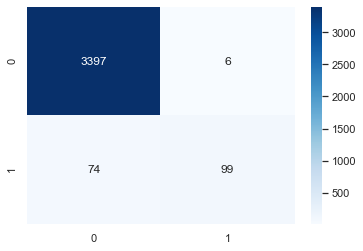

In [87]:
lstm_cm = confusion_matrix(y_test, predict_threshold(lstm_predictions, .5))
sns.heatmap(lstm_cm, annot=True, fmt = 'd', cmap = 'Blues');

print("ROC AUC:", roc_auc_score(y_test, lstm_predictions))
print("Precision:", precision_score(y_test, predict_threshold(lstm_predictions, .5)))
print("Recall:", recall_score(y_test, predict_threshold(lstm_predictions, .5)))

# Trial 2:

In [149]:
def get_LSTM_GRU_model(dropout, n_size, use_GRU: False):
    inp = Input(shape=(max_len,)) #length of sentence
    
    x=Embedding(max_features, embed_size, weights=[embed_matrix])(inp)
    x=Dense(n_size, activation='relu')(x)
    x=SpatialDropout1D(dropout)(x)
    
    if use_GRU:
        x=Bidirectional(GRU(n_size, return_sequences=True))(x)
    else:    
        x=Bidirectional(LSTM(n_size, return_sequences=True))(x)
    
    avg_pool = GlobalAvgPool1D()(x)
    max_pool = GlobalMaxPool1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(1, activation='sigmoid')(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model
    

In [150]:
model_2 = get_LSTM_GRU_model(.2, 64, True)

In [90]:
model_2.fit(X_train, y_train, batch_size=32, epochs=2)

Train on 14304 samples
Epoch 1/2
14304/14304 [==============================] - 109s 8ms/sample - loss: 0.1564 - accuracy: 0.9566
Epoch 2/2
14304/14304 [==============================] - 107s 7ms/sample - loss: 0.0692 - accuracy: 0.9799


In [91]:
gru_predictions = model_2.predict(X_test, batch_size=1024)

In [92]:
roc_auc_score(y_test, gru_predictions)

0.9568283000888369

In [93]:
for i in np.linspace(0, 1, 9):
    print(i)
    prec_score = precision_score(y_test, predict_threshold(lstm_predictions, i))
    rec_score = recall_score(y_test, predict_threshold(lstm_predictions, i))
    total = prec_score + rec_score
    print('Precision:', prec_score)
    print('Recall:', rec_score)
    print('Total:', total)
    print('\n')

0.0
Precision: 0.04837807606263982
Recall: 1.0
Total: 1.0483780760626398


0.125
Precision: 0.7411764705882353
Recall: 0.7283236994219653
Total: 1.4695001700102006


0.25
Precision: 0.8518518518518519
Recall: 0.6647398843930635
Total: 1.5165917362449153


0.375
Precision: 0.8852459016393442
Recall: 0.6242774566473989
Total: 1.5095233582867431


0.5
Precision: 0.9428571428571428
Recall: 0.5722543352601156
Total: 1.5151114781172583


0.625
Precision: 0.968421052631579
Recall: 0.5317919075144508
Total: 1.5002129601460297


0.75
Precision: 1.0
Recall: 0.5028901734104047
Total: 1.5028901734104045


0.875
Precision: 1.0
Recall: 0.4277456647398844
Total: 1.4277456647398843


1.0
Precision: 0.0
Recall: 0.0
Total: 0.0




C:\Users\lzeng\AppData\Local\Continuum\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ROC AUC: 0.9568283000888369
Precision: 0.9711538461538461
Recall: 0.5838150289017341


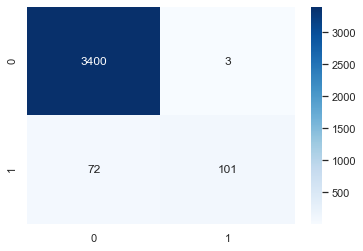

In [94]:
gru_cm = confusion_matrix(y_test, predict_threshold(gru_predictions, .625))
sns.heatmap(gru_cm, annot=True, fmt = 'd', cmap = 'Blues');

print("ROC AUC:", roc_auc_score(y_test, gru_predictions))
print("Precision:", precision_score(y_test, predict_threshold(gru_predictions, .625)))
print("Recall:", recall_score(y_test, predict_threshold(gru_predictions, .625)))

# 3. Mixed Data Model:

### Feature Generation:

In [189]:
#Create non-sequential features:
X_nonseq = data[['telecommuting', 'has_company_logo', 'has_questions', 'has_salary',
             'num_nums', 'num_links', 'num_punct', 'description_length']].copy()

X_nonseq = pd.concat([X_nonseq, employment_df], axis = 1)
X_nonseq['has_salary'] = X_nonseq['has_salary'].astype('int')

#Sequential Features:
X_seq = X.copy()

In [200]:
print(X_nonseq.shape, X_seq.shape, y.shape)

(17880, 14) (17880, 300) (17880,)


In [201]:
X_nonseq_train, X_nonseq_test, y_train, y_test = train_test_split(X_nonseq, y, test_size = .2, 
                                                                  stratify = y, random_state = 1000)

In [203]:
X_seq_train = X_seq[X_nonseq_train.index]
X_seq_test = X_seq[X_nonseq_test.index]

In [204]:
print(X_seq_train.shape, X_nonseq_train.shape)

(14304, 300) (14304, 14)


In [170]:
def create_nonseq_model(dim, n_size, output_dim):
    inp = Input(shape=(dim, ))
    
    x = Dense(n_size, activation='relu')(inp)
    x = Dense(output_dim, activation='relu')(x)
    
    model = Model(inputs=inp, outputs=x)
    
    return model

In [127]:
def create_seq_model(n_size, dropout, output_dim):
    inp = Input(shape=(max_len,)) #length of sentence
    
    x=Embedding(max_features, embed_size, weights=[embed_matrix])(inp)
    x=Dense(n_size, activation='relu')(x)
    x=SpatialDropout1D(dropout)(x)

    x=Bidirectional(LSTM(n_size, return_sequences=True))(x)
    
    avg_pool = GlobalAvgPool1D()(x)
    max_pool = GlobalMaxPool1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(output_dim, activation='relu')(conc)
    
    model = Model(inputs=inp, outputs=outp)
    
    return model

In [214]:
def create_mixed_model(output_dim_seq, output_dim_nonseq, n_size):
    nonseq = create_nonseq_model(X_nonseq_train.shape[1], n_size = 100, output_dim=output_dim_nonseq)
    seq = create_seq_model(128, .2, output_dim_seq)
    
    combined_input = concatenate([nonseq.output, seq.output])
    
    x = Dense(n_size, activation = 'relu')(combined_input)
    x = Dense(1, activation = 'sigmoid')(x)
    
    model = Model(inputs=[nonseq.inputs, seq.inputs], outputs=x)

    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model

In [217]:
backend.clear_session()
mixed = create_mixed_model(32, 128, 128)
mixed.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 300)     9000000     input_2[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 300, 128)     38528       embedding[0][0]                  
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 300, 128)     0           dense_2[0][0]                    
____________________________________________________________________________________________

In [218]:
mixed.fit([X_nonseq_train, X_seq_train], y_train, batch_size=32, epochs=2)

Train on 14304 samples
Epoch 1/2
14304/14304 [==============================] - 230s 16ms/sample - loss: 1.1357 - accuracy: 0.9242
Epoch 2/2
14304/14304 [==============================] - 223s 16ms/sample - loss: 0.2431 - accuracy: 0.9560


In [219]:
mixed_preds = mixed.predict([X_nonseq_test, X_seq_test], batch_size = 1024)

In [220]:
roc_auc_score(y_test, mixed_preds)

0.9243900740421152

In [221]:
average_precision_score(y_test, mixed_preds)

0.770725600865585

In [222]:
average_precision_score(y_test, lstm_predictions)

0.8072403433177581